<a href="https://colab.research.google.com/github/marreapato/Forecasting-BVSP-Deep-Learning/blob/main/Baseline_Projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import the yfinance. If you get module not found error the run !pip
#install yfinance from your Jupyter notebook
import yfinance as yf
from numpy.random import seed
import tensorflow as tf
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from numpy import genfromtxt
from pandas_datareader import data as pdr
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import mannwhitneyu
# Get the data for the stock AAPL
data = yf.download('^BVSP','2007-01-01','2023-10-17')

data.head(7)


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-02,44476.0,45388.0,44476.0,45383.0,45383.0,75560200
2007-01-03,45379.0,45379.0,44284.0,44445.0,44445.0,122372800
2007-01-04,44442.0,44442.0,43623.0,44020.0,44020.0,86577000
2007-01-05,44019.0,44081.0,42160.0,42245.0,42245.0,164055000
2007-01-08,42249.0,42926.0,42144.0,42830.0,42830.0,114007100
2007-01-09,42831.0,43001.0,41438.0,42007.0,42007.0,112991900
2007-01-10,42001.0,42336.0,41266.0,42336.0,42336.0,110755900


In [ ]:
def GRU_Model(output_window):
  model = Sequential()
  model.add(GRU(128, return_sequences=False, input_shape=(X.shape[1],1)))
  model.add(Dense(output_window))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  return model

In [ ]:
def LSTM_Model(output_window):
  model = Sequential()
  model.add(LSTM(128, return_sequences=False, input_shape=(X.shape[1],1)))
  model.add(Dense(output_window))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.summary()
  return model

In [ ]:
#Based on: Computer Science: Stock Price Prediction Using Python & Machine Learning. https://www.youtube.com/watch?v=QIUxPv5PJOY (2019), accessed 25 January,
#2022
def data_preparation(w, scaled_data, N, f):
  X=[]
  window = w + f
  Q = len(scaled_data)
  for i in range(Q-window+1):
    X.append(scaled_data[i:i+window, 0])

  X = np.array(X)
  X = np.reshape(X, (X.shape[0],X.shape[1],1))

  trainX, trainY = X[0:N,0:w], X[0:N,w:w+f]
  testX, testY = X[N:Q-w,0:w], X[N:Q-w,w:w+f]
  X = trainX
  return trainX, trainY, testX, testY, X

In [ ]:
#Repeats the last known value f times
def baselinef(U,f):
  last = U.shape[0]
  yhat = np.zeros((last, f))
  for j in range(0,last):
    yhat[j,0:f] = np.repeat(U[j,U.shape[1]-1], f)
  return yhat

In [ ]:
#Directional accuracy
#From https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9
def mda(actual: np.ndarray, predicted: np.ndarray):
  return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [ ]:
#Normalize data between 0 and 1
def scaleit(DATAX):
  mima = np.zeros((DATAX.shape[0], 2)) #To save min and max values
  for i in range(DATAX.shape[0]):
    mima[i,0],mima[i,1] = DATAX[i,:].min(), DATAX[i,:].max()
    DATAX[i,:] = (DATAX[i,:]-DATAX[i,:].min())/(DATAX[i,:].max()-DATAX[i,:].min())
  return DATAX, mima

In [ ]:
#Rescale to original values
def rescaleit(y,mima,i):
  yt = (y*(mima[i,1]-mima[i,0]))+mima[i,0]
  return yt

In [ ]:
# Define a function to plot multiple series
def plot_series(stock_data):
    # Create a new figure
    plt.figure(figsize=(12, 6))

    # Plot 'Adj Close' price in blue
    plt.plot(stock_data['Adj Close'], label='Adj Close', color='blue')

    # Plot 'Adj Close' price in blue
    plt.plot(stock_data['Open'], label='Open', color='orange')

    # Plot 'High' price in green
    plt.plot(stock_data['High'], label='High', color='green')

    # Plot 'Low' price in red
    plt.plot(stock_data['Low'], label='Low', color='red')

    # Plot 'Close' price in purple
    plt.plot(stock_data['Close'], label='Close', color='purple')

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Price Series')
    plt.legend()

    # Show the plot
    plt.show()

In [ ]:
#Statistical tests
def statisticaltests(s):
  print('LSTM and Baseline (RMSE)')
  U1, p = mannwhitneyu(s[:,0],s[:,2], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('GRU and Baseline (RMSE)')
  U1, p = mannwhitneyu(s[:,1],s[:,2], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('LSTM and GRU (RMSE)')
  U1, p = mannwhitneyu(s[:,0],s[:,1], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('LSTM and Baseline (DA)')
  U1, p = mannwhitneyu(s[:,0+3],s[:,2+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('GRU and Baseline (DA)')
  U1, p = mannwhitneyu(s[:,1+3],s[:,2+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('LSTM and GRU (DA)')
  U1, p = mannwhitneyu(s[:,0+3],s[:,1+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))

In [ ]:
#Based on https://stackoverflow.com/questions/12236566/setting-different-color-for-each-series-in-scatter-plot-on-matplotlib
#This code is to plot series of different colors
def plot_series_np(X):
  x = np.arange(1)
  ys = [i+x+(i*x)**2 for i in range(1)]
  colors = cm.rainbow(np.linspace(0, 1, len(ys)))
  for i in range(1):
    plt.plot(X[i], label='%s ' % (i+1), color=colors[i,:])
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
  plt.xlabel("Days")
  plt.ylabel("Closing Price")

In [ ]:
data.replace(np.nan, 0.0, inplace=True)
data.isnull().values.any()#check if nan are still there


False

In [ ]:
data['Close']

Date
2007-01-02     45383.0
2007-01-03     44445.0
2007-01-04     44020.0
2007-01-05     42245.0
2007-01-08     42830.0
                ...   
2023-10-09    115156.0
2023-10-10    116737.0
2023-10-11    117051.0
2023-10-13    115754.0
2023-10-16    116534.0
Name: Close, Length: 4154, dtype: float64

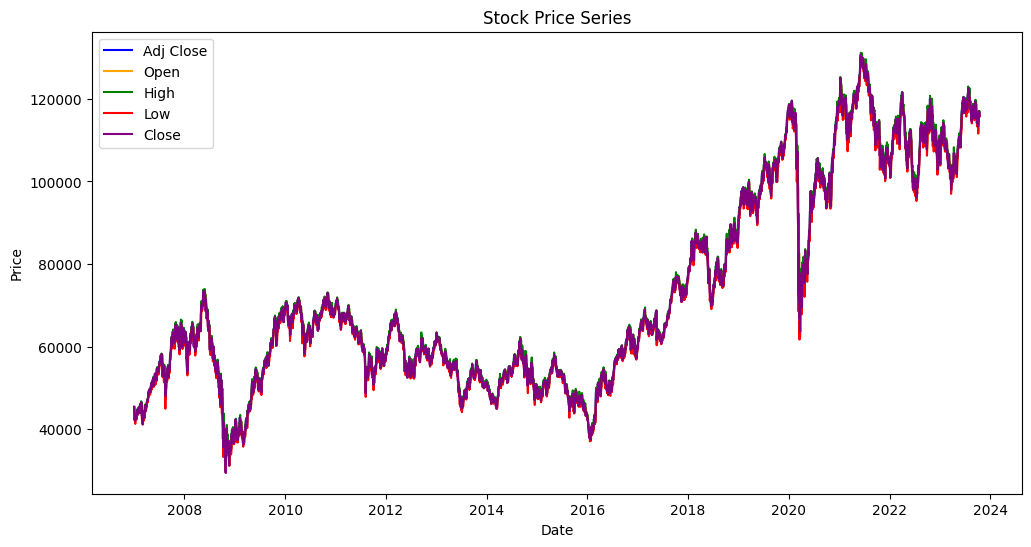

In [ ]:
plot_series(data)

In [ ]:
DATAX = data['Close'].to_numpy()
DATAX=DATAX.reshape(-1,1)
DATAX.shape

(4154, 1)

In [ ]:
DATAX

array([[ 45383.],
       [ 44445.],
       [ 44020.],
       ...,
       [117051.],
       [115754.],
       [116534.]])

In [ ]:
#Normalize data between 0 and 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(DATAX)

In [ ]:
scaled_data

array([[0.15736967],
       [0.14811379],
       [0.14392003],
       ...,
       [0.86456617],
       [0.85176779],
       [0.85946458]])

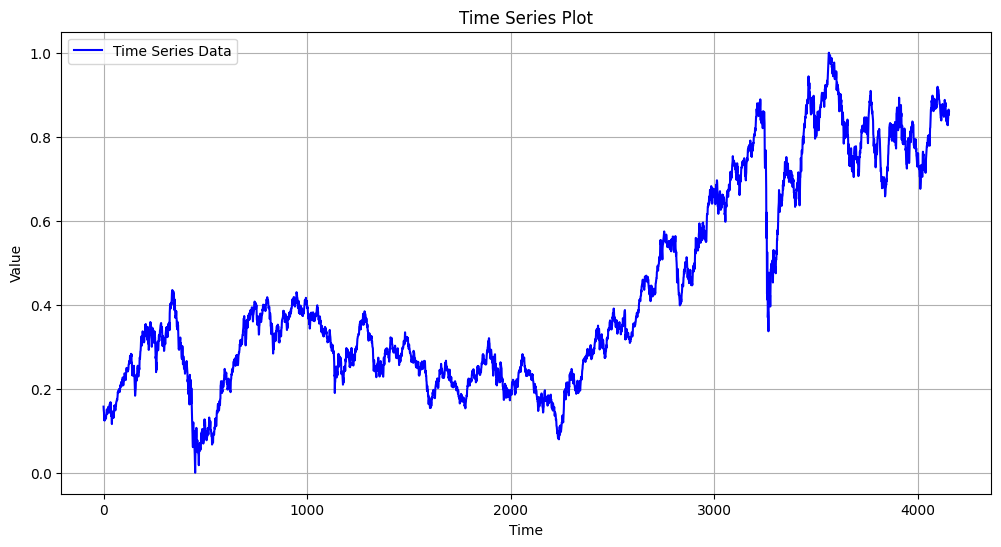

In [ ]:
# as the time values and another NumPy array for the data points.
time_values = np.arange(0, len(scaled_data), 1)  # Time values, e.g., from 0 to 10 with a step of 0.1
time_series_data = scaled_data  # Example time series data (sine wave)

# Create a figure and plot the time series
plt.figure(figsize=(12, 6))
plt.plot(time_values, time_series_data, label='Time Series Data', color='blue')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Plot')

# Show a legend (if multiple series are plotted)
plt.legend()

# Show the plot
plt.grid(True)  # You can add grid lines if needed
plt.show()

In [ ]:
#w < N < Q
window = 60 #Size of the window in days
test_samples = 251 #Number of test samples
f = 20 #Size of future window in days. Change f for the number of steps-ahead. 1 or 20.
N = len(scaled_data) - test_samples - window

In [ ]:
trainX, trainY, testX, testY, X = data_preparation(window, scaled_data, N,f)

In [ ]:
lstm_model = LSTM_Model(f)
gru_model = GRU_Model(f)
epochs = 10

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 20)                2580      
                                                                 
Total params: 69140 (270.08 KB)
Trainable params: 69140 (270.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               50304     
                                                                 
 dense_1 (Dense)             (None, 20)                2580      
                                                              

In [ ]:
# Train LSTM model
lstm_trained = lstm_model.fit(trainX, trainY, shuffle=True, epochs=epochs)
# Train GRU model
gru_trained = gru_model.fit(trainX, trainY, shuffle=True, epochs=epochs)

Epoch 1/10
121/121 [==============================] - 10s 13ms/step - loss: 0.0159
Epoch 2/10
121/121 [==============================] - 1s 12ms/step - loss: 0.0024
Epoch 3/10
121/121 [==============================] - 1s 9ms/step - loss: 0.0022
Epoch 4/10
121/121 [==============================] - 2s 13ms/step - loss: 0.0021
Epoch 5/10
121/121 [==============================] - 1s 11ms/step - loss: 0.0019
Epoch 6/10
121/121 [==============================] - 1s 12ms/step - loss: 0.0019
Epoch 7/10
121/121 [==============================] - 1s 10ms/step - loss: 0.0018
Epoch 8/10
121/121 [==============================] - 1s 12ms/step - loss: 0.0019
Epoch 9/10
121/121 [==============================] - 2s 13ms/step - loss: 0.0017
Epoch 10/10
121/121 [==============================] - 2s 13ms/step - loss: 0.0018
Epoch 1/10
121/121 [==============================] - 3s 6ms/step - loss: 0.0192
Epoch 2/10
121/121 [==============================] - 1s 5ms/step - loss: 0.0017
Epoch 3/10
121/12

In [ ]:
y_pred_lstm = lstm_model.predict(testX)
y_pred_gru = gru_model.predict(testX)
y_baseline = baselinef(testX,f)
testY = np.reshape(testY, (testY.shape[0],testY.shape[1]))
print(testY.shape)
np.sqrt(mean_squared_error(testY, y_pred_lstm))


8/8 [==============================] - 0s 3ms/step
(232, 20)


0.03942178497899856

In [ ]:
np.sqrt(mean_squared_error(testY, y_pred_gru))


0.04672544757464366

In [ ]:
np.sqrt(mean_squared_error(testY, y_baseline))

0.03758518527305382

In [ ]:
mda(testY, y_pred_lstm)


0.49047619047619045

In [ ]:
mda(testY, y_pred_gru)


0.49913419913419915

In [ ]:
mda(testY, y_baseline)

0.4997835497835498

In [ ]:
s=(1,6)
s=np.ones(s)  #for the results
s[0,0]=np.sqrt(mean_squared_error(testY, y_pred_lstm))
s[0,1]=np.sqrt(mean_squared_error(testY, y_pred_gru))
s[0,2]=np.sqrt(mean_squared_error(testY, y_baseline))
s[0,3]=mda(testY, y_pred_lstm)
s[0,4]=mda(testY, y_pred_gru)
s[0,5]=mda(testY, y_baseline)
s


array([[0.03942178, 0.04672545, 0.03758519, 0.49047619, 0.4991342 ,
        0.49978355]])

In [ ]:
statisticaltests(s)

LSTM and Baseline (RMSE)
U=1.0. p = 1.0
GRU and Baseline (RMSE)
U=1.0. p = 1.0
LSTM and GRU (RMSE)
U=0.0. p = 1.0
LSTM and Baseline (DA)
U=0.0. p = 1.0
GRU and Baseline (DA)
U=0.0. p = 1.0
LSTM and GRU (DA)
U=0.0. p = 1.0


In [ ]:
# To return the original data from the scaled data
original_data_y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
original_data_y_pred_lstm

array([[117049.055, 118670.516, 116905.07 , ..., 117719.56 , 117964.78 ,
        117631.59 ],
       [116818.66 , 118195.03 , 116272.56 , ..., 117108.02 , 117511.68 ,
        117123.97 ],
       [116542.266, 117645.86 , 115731.43 , ..., 116592.32 , 117007.375,
        116596.63 ],
       ...,
       [117652.69 , 118194.9  , 116870.76 , ..., 118048.766, 118005.336,
        117463.79 ],
       [117889.195, 118510.97 , 117238.04 , ..., 118427.57 , 118307.03 ,
        117786.69 ],
       [118112.11 , 118824.61 , 117532.53 , ..., 118734.95 , 118603.51 ,
        118087.086]], dtype=float32)

In [ ]:
# To return the original data from the scaled data
original_data_y_pred_gru = scaler.inverse_transform(y_pred_gru)
original_data_y_pred_gru

array([[119058.69 , 118603.71 , 118257.836, ..., 116294.43 , 116821.42 ,
        116234.92 ],
       [117758.36 , 116990.79 , 116696.56 , ..., 114762.5  , 115385.59 ,
        114891.72 ],
       [117062.4  , 116531.14 , 116185.75 , ..., 114594.31 , 115075.61 ,
        114314.93 ],
       ...,
       [121527.6  , 121224.42 , 120799.63 , ..., 119130.984, 119498.305,
        118866.38 ],
       [122400.29 , 122266.945, 121815.86 , ..., 120089.34 , 120433.15 ,
        119757.266],
       [122903.625, 122653.336, 122228.61 , ..., 120314.53 , 120732.68 ,
        120192.54 ]], dtype=float32)

In [ ]:
# To return the original data from the scaled data
original_data_y_pred_bsline = scaler.inverse_transform(y_baseline)
original_data_y_pred_bsline

array([[114300., 114300., 114300., ..., 114300., 114300., 114300.],
       [112072., 112072., 112072., ..., 112072., 112072., 112072.],
       [113624., 113624., 113624., ..., 113624., 113624., 113624.],
       ...,
       [118176., 118176., 118176., ..., 118176., 118176., 118176.],
       [119392., 119392., 119392., ..., 119392., 119392., 119392.],
       [118758., 118758., 118758., ..., 118758., 118758., 118758.]])

Text(0, 0.5, 'Value')

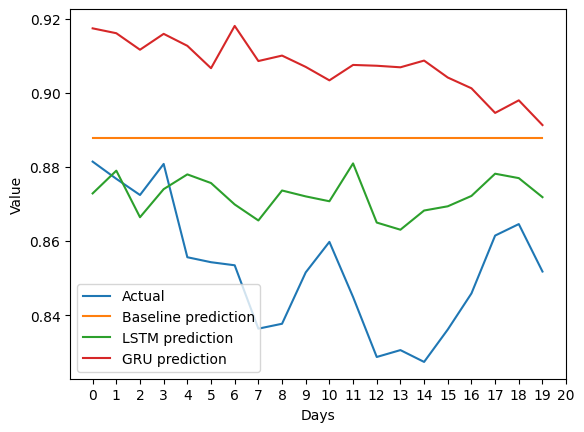

In [ ]:
g = 230 #Chooses one of the tests samples

plt.plot(testY[g,:], label = 'Actual')
plt.plot(y_baseline[g,:], label = 'Baseline prediction')
plt.plot(y_pred_lstm[g,:], label = 'LSTM prediction')
plt.plot(y_pred_gru[g,:], label = 'GRU prediction')
plt.legend()
plt.xlabel('Days')
days = np.arange(testY.shape[1]+1)
new_list = range(math.floor(min(days)), math.ceil(max(days))+1)
plt.xticks(new_list)
plt.ylabel('Value')

Text(0, 0.5, 'MSE Loss')

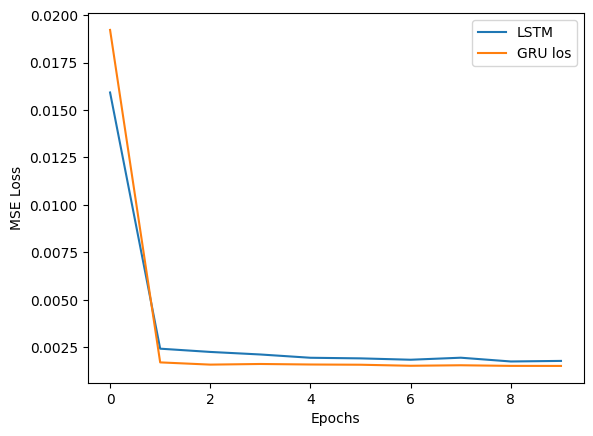

In [ ]:
#"""Plot loss function and Predictions"""
plt.plot(lstm_trained.history['loss'], label = 'LSTM')
plt.plot(gru_trained.history['loss'], label = 'GRU los')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')

In [ ]:
# Choose a specific input sequence to explain
input_sequence = testX[1, :, 0]  # Assuming your input_sequence is (60,) shape

# Predict using your LSTM model
forecast = y_pred_lstm

# Ensure that forecast has the same number of time steps as input_sequence
forecast = forecast[[1,2,3],:]

forecast=forecast.reshape(60)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


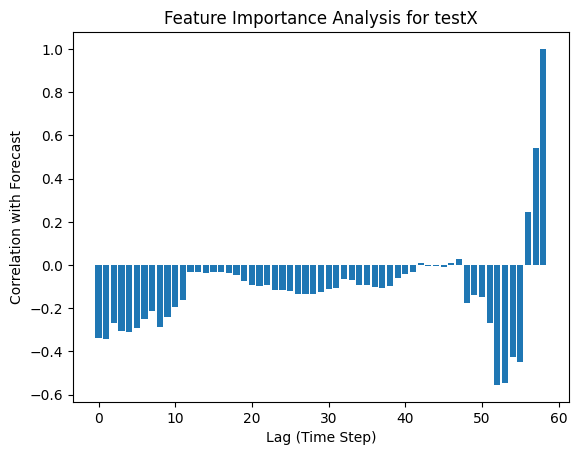

In [ ]:
# Calculate the correlation between each lag and the forecast
correlations = [np.corrcoef(input_sequence[i:], forecast[i:])[0, 1] for i in range(len(input_sequence))]

# Plot the correlations to visualize the importance of each lag
plt.bar(range(len(input_sequence)), correlations)
plt.xlabel('Lag (Time Step)')
plt.ylabel('Correlation with Forecast')
plt.title('Feature Importance Analysis for testX')
plt.show()

In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9efbd24e7f74b85167d0aada678dbd2a3c0401be89b5a96536cb76f0959cf517
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
testXresh=testX.reshape(-1)
trainXresh=trainX.reshape(-1)

(230580,)

In [ ]:
from lime.lime_tabular import LimeTabularExplainer


# Initialize the LIME explainer
explainer = LimeTabularExplainer(training_data=trainX, mode="regression")


# Explain the forecast for a specific test instance
test_instance = testY[0]
explanation = explainer.explain_instance(test_instance, predict_function)

# Print the explanation
explanation.show_in_notebook()
explanation.show_in_notebook()

IndexError: ignored